In [1]:
# Importation des libraries/packages de base. 

import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [7]:
# Fichier avec les variables d'intéret : dernière version : 21/02 

# df_cct = pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/df_all.parquet")

In [8]:
#creation de 2000 parquets (1 par user)
#for k in range (2000):
    #df=df_cct[df_cct['User']==k]
    #df.to_parquet('/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_all/df_all'+ str(k)+'.parquet')



In [24]:
from sklearn import preprocessing
#fonction qui retire les colonnes inutiles, qui cree la colonne 'Number_year_since_PIN_last_Changed' qui
    #qui cree des dummies a partir des variable categorielle et qui normalise les variables non-categorielles

def modification_data_frame(df_cct):
    
    #On retire les colonnes qui ne sont plus utiles
    df_cct =  df_cct.drop([  'day_of_week','Card', 'Month', 'Day', 'Hours'], axis = 1)
    
    
    #pour ne pas avoir de soucis lors de la concatenations des dataframe (df_cct et dummies), on reinitialise les index
    df_cct=df_cct.reset_index()    
    df_cct =  df_cct.drop(["index"], axis = 1)

    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    features_array = enc.fit_transform(df_cct[['Card Brand']]).toarray()
    features_labels = np.hstack(np.array(enc.categories_))
    df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels).reset_index()], axis = 1)

    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    features_array = enc.fit_transform(df_cct[['Use Chip']]).toarray()
    features_labels = np.hstack(np.array(enc.categories_))
    df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels).reset_index()], axis = 1)

    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    features_array = enc.fit_transform(df_cct[['Card Type']]).toarray()
    features_labels = np.hstack(np.array(enc.categories_))
    df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

    df_cct =  df_cct.drop(["index","Card Brand",'Card Type'], axis = 1)
    
    
    
    #On centre et reduit les colonnes a normaliser suivantes:
    Normalizing_List=['Amount', 'Credit Limit', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt',
       'year_diff']
    df_cct_not_normalized=df_cct.copy()
    for i in Normalizing_List:
        if np.std(df_cct[i])!=0:
            df_cct[i] = (df_cct[i]-np.mean(df_cct[i]))/np.std(df_cct[i])
        else:
            df_cct[i] = (df_cct[i]-np.mean(df_cct[i])) 
    return df_cct

In [25]:
# Application de la fonction au 2000 parquet -> on obtient les parquets modifiés et les parquets avec
# les fraudes associees pour chaque utilisatuer dans un seul et même dossier.  
    
    
for k in range (2000):
    df=pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_all/df_all"+str(k)+".parquet")
    
    df_modified=modification_data_frame(df)
    IsFraud=df_modified["Is Fraud?"].to_frame()
    df_modified=df_modified.drop(["Is Fraud?"],axis = 1)
    
    df_modified.to_parquet('/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_modified_all/df_all'+ str(k)+'.parquet')
    IsFraud.to_parquet('/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_modified_all/IsFraud'+ str(k)+'.parquet')


In [25]:
#on ouvre le parquet 200 pour tester
# df200=pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_all/df_all200.parquet").head()
# df200.head()

In [24]:
#on ouvre le parquet 200 pour tester
# df200_modified=pd.read_parquet("/Users/vanheuverswyn/Desktop/ProjetStatapp/parquet_modified_all/df_all200.parquet")
# print(df200_modified.describe())

In [6]:
#fonction qui applique dbScann au dataFrame A finir

    
def dbScann (df_cct):
    X = df_cct.values
    X.astype(np.float64)
    #eps min_sample et n_jobs a déterminer  (fixer le meme pour tous ou automatiser une selection?)
    clustering=cluster.DBSCAN(eps=0.8, min_samples=5, n_jobs = -1)
    clustering.fit(X)
    
def PCS(df_cct):    
    pca = PCA()
    pca.fit(df_cct)
    df_cct.columns = df_cct.columns.astype("str")
    df_cct_pca = pca.transform(df_cct)
    df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
    df_cct_pca_df["labels"] = clustering.labels_



In [ ]:

# df =pd.read_parquet("/home/onyxia/work/Databases/df_all"+str(i)+".parquet")

In [419]:
# Commençons par les 200 premiers Users : 

f = os.listdir("/home/onyxia/work/Datasets")
f = [v for v in f if "df_all" in v][:200]


In [420]:
# Création d'une liste de dataframe :

df_cct1 = [pd.read_parquet("/home/onyxia/work/Datasets/" + v) for v in f]

In [421]:
# On a déjà retiré les variables catégorielles : on retire aussi User : 
df_cct = [df_cct1[i].drop("User",  axis = "columns") for i in range(len(df_cct1))]

In [119]:
# Fonction pour supprimer les variables catégorielles : 

def reshapedf(df):
    unique_values = {v : df[v].unique() for v in df.columns}
    unique_values = {v : unique_values[v] for v in unique_values.keys() if len(unique_values[v]) <= 2}
    if "Credit Limit" in list(unique_values.keys()) : 
        del unique_values['Credit Limit']
    return df.drop(list(unique_values.keys()), axis = "columns")

In [121]:
from sklearn import cluster 
from collections import Counter

In [122]:
# Fonction pour implémenter DBSCAN sur un dataset et retourne le nbr de cluster : 

def DBSCAN1(df_cct, eps, min_sample):
    X = df_cct.values
    X.astype(np.float64)
    #eps min_sample et n_jobs a déterminer  (fixer le meme pour tous ou automatiser une selection?)
    clustering=cluster.DBSCAN(eps = eps, min_samples = min_sample, n_jobs = -1)
    clustering.fit(X)
    return Counter(clustering.labels_)

In [123]:
# DBSCAN + insérer le label dans une nouvelle variable pour chaque transaction. 

def DBSCAN2(df, eps, min_sample):
    X = df.values
    X.astype(np.float64)
    #eps min_sample et n_jobs a déterminer  (fixer le meme pour tous ou automatiser une selection?)
    clustering=cluster.DBSCAN(eps = eps, min_samples = min_sample, n_jobs = -1)
    clustering.fit(X)
    df.insert(1,"label", clustering.labels_)
    return df

In [124]:
# Fonctions pour calculer la distance moyenne entre les points : trouver eps : 

def Euclid_distance(point1, point2):
    return np.linalg.norm(point1 - point2)
    
def Transac_distance(point1, set2):
    return np.mean([Euclid_distance(point1, point2) for point2 in set2])

def User_distance(User):
    return np.mean([Transac_distance(point1, User) for point1 in User])


In [293]:
# Choix de eps : 
#User_distance(df_cct[0].values) # 4.069

In [387]:
# Test : trouver min_sample : idée : 0.002*df.shape[0] : regarder un peu le nbr de cluster et effectif : 
[DBSCAN1(df, 2.5, max(2,round(0.002*df.shape[0]))) for df in df_cct[:20]]
# 2.5 satisfaisant pour eps : regarder nbr de cluster et effectif 

[Counter({-1: 418, 0: 15042, 1: 272}),
 Counter({0: 47, -1: 7, 1: 2}),
 Counter({0: 19004, -1: 556, 1: 355}),
 Counter({0: 7306, -1: 265, 1: 174}),
 Counter({-1: 390, 0: 204, 1: 9715, 2: 28}),
 Counter({-1: 9, 0: 112}),
 Counter({0: 11, -1: 7, 1: 2, 2: 34, 3: 3}),
 Counter({-1: 48, 0: 1729, 1: 11, 2: 150, 3: 7, 4: 24, 5: 10}),
 Counter({0: 24966, -1: 622, 1: 554}),
 Counter({0: 2929, -1: 84, 1: 77, 2: 5, 3: 76}),
 Counter({0: 269, -1: 49, 1: 5, 2: 8, 3: 5, 4: 1413, 5: 17}),
 Counter({0: 9728, 1: 302, -1: 331, 2: 24}),
 Counter({-1: 507, 0: 21974, 1: 427}),
 Counter({0: 12863, -1: 292, 1: 423, 2: 1509}),
 Counter({0: 4449,
          1: 59,
          2: 204,
          -1: 212,
          3: 32,
          6: 23,
          4: 1007,
          5: 23,
          7: 18}),
 Counter({0: 41, -1: 236, 1: 10774, 2: 264}),
 Counter({0: 9140, -1: 248, 2: 227, 1: 603}),
 Counter({0: 16171, 1: 428, 3: 40, -1: 476, 2: 65}),
 Counter({0: 100, 1: 2, -1: 12, 2: 2, 3: 5, 4: 13, 5: 2, 6: 2}),
 Counter({-1: 197

In [422]:
# On affecte le numéro du cluster à chaque transaction : # On test sur les 
df_cct_clustered = [DBSCAN2(df,2.5, max(2,round(0.002*df.shape[0]))) for df in df_cct]

In [423]:
# On rassemble les transactions par label : et on prend la moyenne :  
df_cct_clustered1 = [df.groupby("label").mean().reset_index() for df in df_cct_clustered]

In [424]:
# On rassemble le tout et on fait DBSCAN sur les sous-groupes créés : 
df_final = pd.concat(df_cct_clustered1).reset_index(drop = True).drop("label", axis = "columns")

In [357]:
#User_distance(df_final.values)

In [425]:
DBSCAN1(df_final,2,max(2,round(0.002*df_final.shape[0])))

Counter({0: 595,
         1: 14,
         2: 2,
         -1: 82,
         3: 108,
         4: 2,
         5: 15,
         6: 6,
         7: 3,
         8: 2,
         9: 5,
         10: 3,
         11: 3,
         12: 9,
         13: 2,
         14: 3})

In [426]:
# On a obtenu des groupes par transaction de User => puis des groupes de groupes de transaction de User. 
df_final1 = DBSCAN2(df_final,2,max(2,round(0.002*df_final.shape[0])))

############################################
############################################

In [427]:
df_final1["label"].unique()

array([ 0,  1,  2, -1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [428]:
df_final1

,Amount,label,Credit Limit,year_diff,delta_t_s,delta_t_s_card,amt/daily_income,daily_amount,nb_daily_declines_card,nb_weekly_declines_card,nb_monthly_declines_card,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt
0,1.701182,0,-0.554838,0.408695,0.220138,0.201935,1.701182,4.028080,1.182968,0.991471,0.506329,1.047170,0.730244,2.986989
1,-0.047251,0,0.010827,-0.010274,-0.004693,-0.003679,-0.047251,-0.114810,-0.148595,-0.062590,-0.029429,-0.039514,-0.026954,-0.080199
2,-0.001256,0,0.253896,-0.059878,-0.078760,-0.106897,-0.001256,0.158949,6.399559,1.937671,0.849361,0.575938,0.368395,-0.155173
3,0.866996,0,0.000000,0.000000,0.234966,0.234966,0.866996,0.886391,1.347151,1.072222,0.219382,-0.266760,-0.013971,0.518652
4,-0.044472,0,0.000000,0.000000,0.002368,0.002368,-0.044472,-0.183116,-0.192450,-0.135125,-0.066904,-0.084747,-0.072587,-0.108510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,-0.032759,0,0.000000,0.013098,0.047732,0.047732,-0.032759,-0.126911,-0.279902,-0.112904,-0.060490,-0.074235,-0.052977,-0.076454
850,0.164772,0,0.000000,-0.183240,-0.654100,-0.654100,0.164772,0.692419,3.231869,1.201323,0.513301,0.564417,0.498779,0.041596
851,1.674122,0,-0.737377,0.107295,-0.258997,0.006124,1.674122,2.934388,2.096929,1.494804,0.739916,0.610334,0.567510,2.535649
852,-0.055340,0,0.016788,0.000105,0.015599,0.007737,-0.055340,-0.098515,-0.155608,-0.080298,-0.039354,-0.025794,-0.025428,-0.081624


In [429]:
# Revenir aux User (aux transactions individuelles) : 
# 1. 
df_tt = pd.concat(df_cct_clustered1).reset_index(drop = True)
df_tt.insert(1, "label_global", df_final1["label"])
df_tt["label_global"].unique()

array([ 0,  1,  2, -1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [430]:
# 2. 
# Ajouter la colonne User : au dataset df_tt : (but : relier les labels aux transactions des Users)
def inserte(df,df_final):
    df.insert(1, "label", df_final["label"])
    return df

In [431]:
# 2. 
[inserte(df_cct1[i], df_cct_clustered[i]) for i in range(len(df_cct1))]
df_tt.insert(1,"User",pd.concat([df.groupby("label").mean().reset_index() for df in df_cct1])["User"].reset_index(drop=True))


In [432]:
# 3. 
# Redécouper le dataset par user : 
grouped = df_tt.groupby(df_tt["User"])
Ldf = []
[Ldf.append(grouped.get_group(v)) for v in df_tt["User"].unique()]
Ldf = [Ldf[i].reset_index(drop = True) for i in range(len(Ldf))]
Ldf[1]
# Ils sont dans Ldf.

,label,User,label_global,Amount,Credit Limit,year_diff,delta_t_s,delta_t_s_card,amt/daily_income,daily_amount,nb_daily_declines_card,nb_weekly_declines_card,nb_monthly_declines_card,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt
0,-1,917.0,0,0.866996,0.0,0.0,0.234966,0.234966,0.866996,0.886391,1.347151,1.072222,0.219382,-0.266760,-0.013971,0.518652
1,0,917.0,0,-0.044472,0.0,0.0,0.002368,0.002368,-0.044472,-0.183116,-0.192450,-0.135125,-0.066904,-0.084747,-0.072587,-0.108510
2,1,917.0,1,-1.989393,0.0,0.0,-0.878039,-0.878039,-1.989393,1.200855,-0.192450,-0.577350,0.804400,2.925207,1.754688,0.734714


In [433]:
# 4. 
# Créer une liste de dicts avec la correspondance pour chaque label et label_global par User : 
def corr(df,L):
    return L.append({df["label"][i] : df["label_global"][i] for i in range(len(df))})
    
L = []
[corr(df,L) for df in Ldf]
L[1]

{-1: 0, 0: 0, 1: 1}

In [434]:
# 5. 
# On a les clés de correspondance : maintenant on revient sur le dataset de base : 
# A chaque transaction on affecte la clef global : df_cct_clustered : 
def crea_var(L,df):
    var_glob = []
    [var_glob.append(L[v]) for v in df["label"]]
    df.insert(1,"label_global",var_glob)
    return df
    

df_finalbis = [crea_var(L[i], df_cct1[i]) for i in range(len(L))]

In [435]:
# 6. 
# On supprime les labels propres aux Users pour ne garder que les globaux, représentatifs des groupes de transactions : 
df = pd.concat([df_finalbis[i].drop("label",  axis = "columns") for i in range(len(df_finalbis))]).reset_index(drop = True)

In [436]:
# On regarde a quoi ça ressemble : 
df

,User,label_global,Amount,Credit Limit,year_diff,delta_t_s,delta_t_s_card,amt/daily_income,daily_amount,nb_daily_declines_card,nb_weekly_declines_card,nb_monthly_declines_card,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt
0,1597,0,12.887828,-0.818306,-1.708730,-0.126173,-0.192347,12.887828,7.099077,-0.148595,-0.422143,-0.872388,-0.007741,-0.027158,27.109438
1,1597,0,0.455853,-0.818306,-1.368966,124.291869,122.452113,0.455853,-0.120484,-0.148595,-0.422143,-0.872388,-0.007741,-0.027158,0.843981
2,1597,0,-0.290377,-0.818306,-1.368966,-0.097163,-0.163750,-0.290377,-0.032139,-0.148595,-0.422143,-0.872388,-0.007741,0.710564,0.055689
3,1597,0,-0.259262,-0.818306,-1.368966,-0.107032,-0.173479,-0.259262,0.074274,-0.148595,-0.422143,-0.872388,-0.007741,1.079425,-0.185163
4,1597,0,-0.305308,-0.818306,-1.368966,0.001234,-0.066756,-0.305308,0.153948,-0.148595,-0.422143,-0.872388,-0.007741,1.300742,-0.329909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308894,1952,0,0.180054,0.539818,1.713437,-0.823362,1.697457,0.180054,-0.254274,-0.155608,-0.395208,-0.764566,-0.355323,-1.394104,-0.401911
2308895,1952,0,1.144837,-1.852477,1.713437,1.123806,0.469411,1.144837,0.297349,-0.155608,-0.395208,-0.764566,-0.073078,1.614026,0.468469
2308896,1952,0,-0.399536,0.539818,1.713437,1.412931,1.908884,-0.399536,-0.585659,-0.155608,-0.395208,-0.764566,-0.230695,-1.326540,-0.358690
2308897,1952,0,-0.401934,0.539818,1.713437,-0.813528,-0.805479,-0.401934,-0.582536,-0.155608,-0.395208,-0.764566,1.559915,-0.572437,-0.563982


In [437]:
# Regarder la distribution des Users par label_global : être sur que 1 groupe ne correspond pas à un seul User par exemple. 
# Warning => être sûr qu'on ai pas clusteriser par User au final et non par transaction. 
df.groupby("label_global")['User'].nunique()

label_global
-1      50
 0     200
 1      12
 2       2
 3      72
 4       2
 5      14
 6       6
 7       3
 8       2
 9       5
 10      3
 11      3
 12      9
 13      2
 14      3
Name: User, dtype: int64

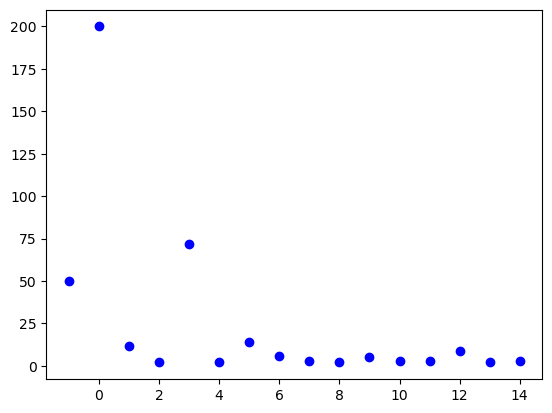

In [438]:
plt.plot(df.groupby("label_global")['User'].nunique(),"ob") # ob = type de points "o" ronds, "b" bleus
plt.show() 

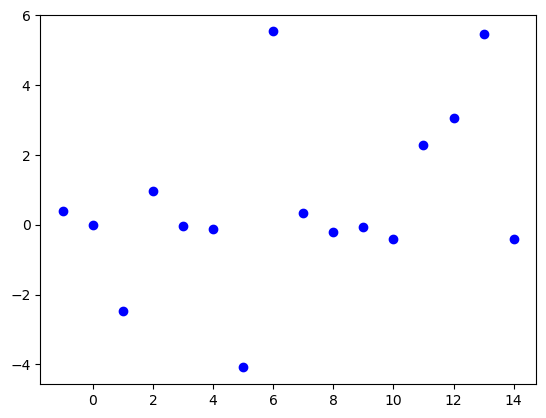

In [439]:
plt.plot(df.groupby("label_global").mean()['Amount'],"ob") # ob = type de points "o" ronds, "b" bleus
plt.show() 

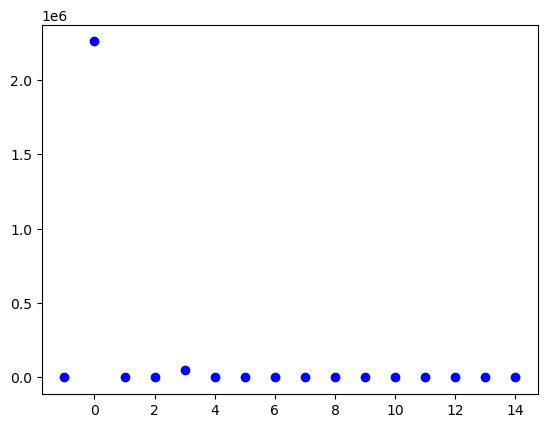

In [440]:
plt.plot(df.groupby("label_global").size(),"ob") # ob = type de points "o" ronds, "b" bleus
plt.show() 

In [442]:
# Exporter le parquet : 
df.to_parquet('/home/onyxia/Projet-Statapp/df.parquet')
